<a href="https://colab.research.google.com/github/pedramaghazadeh/Assembler-Disassembler-with-Python/blob/main/Math_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing useful libraries:

In [ ]:
import tensorflow as tf
import cv2
import os
import easyocr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from lxml import etree

Some incompatibility issues with opencv-python-headless after installing easyocr

In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
imagedir = "../content/drive/MyDrive/Math Lab/data/images"
labeldir = "../content/drive/MyDrive/Math Lab/data/annotations"
images = []
labels = []
imageNames = []
labelNames = []

for name in os.listdir(imagedir):
    imageNames.append(f'{imagedir}/{name}')

imageNames = sorted(imageNames)

for name in imageNames:
    image = cv2.imread(name)
    image = np.asarray(image)
    image = cv2.resize(image, (200, 200))
    images.append(np.asarray(image))
    

for name in os.listdir(labeldir):
    labelNames.append(f'{labeldir}/{name}')
labelNames = sorted(labelNames)

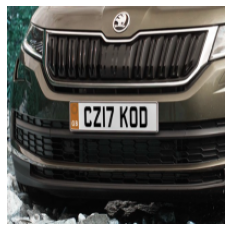

In [ ]:
image = images[12]
plt.axis("off")
plt.imshow(image)

Dataset sample

In [ ]:
for name in labelNames:
    tree = etree.parse(name)
    width = int(tree.xpath("size")[0].xpath("width")[0].text)
    height = int(tree.xpath("size")[0].xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox")[0].xpath("xmin")[0].text) * (200 / width)
    ymin = int(tree.xpath("object/bndbox")[0].xpath("ymin")[0].text) * (200 / height)
    xmax = int(tree.xpath("object/bndbox")[0].xpath("xmax")[0].text) * (200 / width)
    ymax = int(tree.xpath("object/bndbox")[0].xpath("ymax")[0].text) * (200 / height)
    labels.append([int(xmin), int(ymin), int(xmax), int(ymax)])

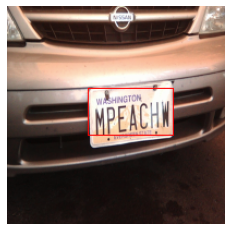

In [ ]:
ind = 292
plt.imshow(images[ind])
image = cv2.rectangle(images[ind], (labels[ind][0], labels[ind][1]), (labels[ind][2], labels[ind][3]), (255, 0, 0), 1)
plt.axis("off")
plt.imshow(image)

Normalizing vectors

In [ ]:
images = np.asarray(images)
labels = np.asarray(labels)
images = images / 255
labels = labels / 255

Splitting data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size = 0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

Importing model

In [ ]:
from keras.models import Sequential #Model is sequential
from keras.layers import Dense, Flatten #Dense for each layer, Flatten for linear
from keras.applications.vgg16 import VGG16 #Image classifier model

**include_top**: whether to include the 3 fully-connected layers at the top of the network.

**weights**: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

**input_shape** : pretty obvious :D

In [ ]:
model = Sequential()
model.add(VGG16(include_top = False, weights = "imagenet", input_shape = images[0].shape))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(4, activation = "sigmoid")) #Output layer

model.layers[-6].trainable = False #Decreasing trainable params

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
trained_model = model.fit(X_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_data = (X_validation, y_validation))

Epoch 1/20
3/3 [==============================] - 24s 4s/step - loss: 0.0614 - accuracy: 0.2857 - val_loss: 0.0824 - val_accuracy: 0.6667
Epoch 2/20
3/3 [==============================] - 1s 239ms/step - loss: 0.0876 - accuracy: 0.4545 - val_loss: 0.0467 - val_accuracy: 0.6667
Epoch 3/20
3/3 [==============================] - 1s 240ms/step - loss: 0.0451 - accuracy: 0.5974 - val_loss: 0.0378 - val_accuracy: 0.5556
Epoch 4/20
3/3 [==============================] - 1s 244ms/step - loss: 0.0359 - accuracy: 0.5844 - val_loss: 0.0271 - val_accuracy: 0.7778
Epoch 5/20
3/3 [==============================] - 1s 238ms/step - loss: 0.0217 - accuracy: 0.5844 - val_loss: 0.0159 - val_accuracy: 0.5556
Epoch 6/20
3/3 [==============================] - 1s 235ms/step - loss: 0.0146 - accuracy: 0.6494 - val_loss: 0.0256 - val_accuracy: 0.6667
Epoch 7/20
3/3 [==============================] - 1s 240ms/step - loss: 0.0233 - accuracy: 0.7143 - val_loss: 0.0179 - val_accuracy: 0.6667
Epoch 8/20
3/3 [======

verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

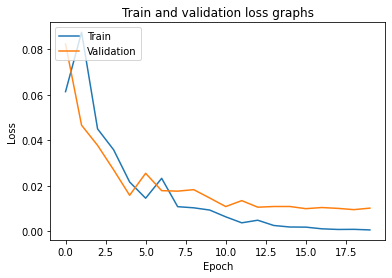

In [ ]:
plt.plot(trained_model.history["loss"])
plt.plot(trained_model.history["val_loss"])
plt.title("Train and validation loss graphs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

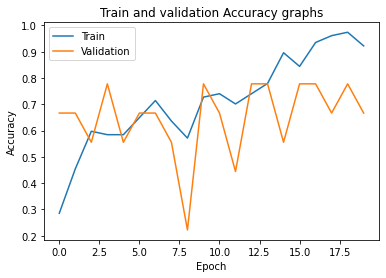

In [ ]:
plt.plot(trained_model.history["accuracy"])
plt.plot(trained_model.history["val_accuracy"])
plt.title("Train and validation Accuracy graphs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

In [ ]:
text = easyocr.Reader(['en'])

In [ ]:
y_cnn = model.predict(X_test)

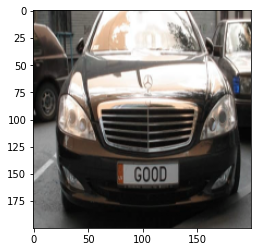

In [ ]:
ind = 72
plt.imshow(X_test[ind])

[[[[11, 25], [43, 25], [43, 43], [11, 43]], 'Good ']]


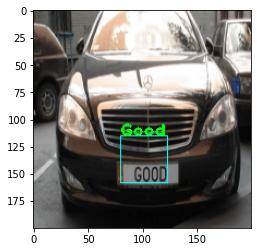

In [ ]:

y = np.copy(y_cnn[ind])
y = y * 255

cropped = X_test[ind][int(y[1]) : int(y[3]), int(y[0]) : int(y[2])]

cropped = (cropped * 255).astype("uint8")

result = text.readtext(cropped, paragraph = "False")

img = cv2.rectangle(np.copy(X_test[ind]  * 255).astype("uint8"), 
                    (int(y[0]), int(y[1])), 
                    (int(y[2]), int(y[3])), (0, 255, 255), 1)
print(result)
if(len(result) > 0):
  cv2.putText(img, result[0][1], (int(y[0]), int(y[1])), cv2.FONT_HERSHEY_PLAIN,
              1, (0, 255, 0), 2)

plt.imshow(img)
plt.show()